# Comprehensive Classification Evaluation: Synthetic Headlines vs Baseline Methods

This notebook evaluates the effectiveness of our synthetic headline generation approach compared to traditional data balancing methods for fake vs real headline classification.

## 🎯 **Experimental Design**

### **4 Dataset Conditions:**
1. **Original Imbalanced** - Raw headlines dataset as-is
2. **Random Oversampling** - Traditional SMOTE/random oversampling
3. **Random Undersampling** - Reduce majority class size
4. **Synthetic Headlines** - Our GPT-generated fake headlines

### **4 Classification Models:**
- **Random Forest** (primary focus with Count Vectorization)
- **Logistic Regression**
- **SVM (Support Vector Machine)**
- **Naive Bayes**

### **Key Metrics:**
- **Accuracy**: Overall classification performance
- **F1-Score**: Balanced measure (especially important for imbalanced data)
- **Precision & Recall**: For both fake (0) and real (1) classes
- **ROC-AUC**: Model discrimination ability

### **Goal:**
Demonstrate that our synthetic headline generation approach provides superior performance compared to traditional balancing methods.

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve
)

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

# Sampling methods
from sklearn.utils import resample
try:
    from imblearn.over_sampling import RandomOverSampler
    from imblearn.under_sampling import RandomUnderSampler
    IMBLEARN_AVAILABLE = True
except ImportError:
    IMBLEARN_AVAILABLE = False
    print("⚠️ imbalanced-learn not available, using sklearn alternatives")

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("📚 Libraries imported successfully!")
print(f"🕐 Experiment timestamp: {datetime.now()}")
print(f"🔧 imbalanced-learn available: {IMBLEARN_AVAILABLE}")
print("🎯 Ready for comprehensive classification evaluation!")

⚠️ imbalanced-learn not available, using sklearn alternatives
📚 Libraries imported successfully!
🕐 Experiment timestamp: 2025-10-30 08:37:40.744528
🔧 imbalanced-learn available: False
🎯 Ready for comprehensive classification evaluation!


## 📊 Dataset Loading & Preparation

In [3]:
# Load original real/fake headlines datasets
print("📥 Loading original headlines datasets...")

# Load real headlines from GossipCop and PolitiFact
try:
    gossipcop_real = pd.read_csv('../data/headlines/gossipcop_real.csv')
    politifact_real = pd.read_csv('../data/headlines/politifact_real.csv')
    print(f"  ✅ GossipCop real: {len(gossipcop_real):,} headlines")
    print(f"  ✅ PolitiFact real: {len(politifact_real):,} headlines")
except FileNotFoundError as e:
    print(f"  ❌ Error loading real headlines: {e}")
    print("  Please ensure the real headlines CSV files are available")

# Load fake headlines from GossipCop and PolitiFact  
try:
    gossipcop_fake = pd.read_csv('../data/headlines/gossipcop_fake.csv')
    politifact_fake = pd.read_csv('../data/headlines/politifact_fake.csv')
    print(f"  ✅ GossipCop fake: {len(gossipcop_fake):,} headlines")
    print(f"  ✅ PolitiFact fake: {len(politifact_fake):,} headlines")
except FileNotFoundError as e:
    print(f"  ❌ Error loading fake headlines: {e}")
    print("  Please ensure the fake headlines CSV files are available")

# Load our synthetic headlines
try:
    # Load the specific synthetic headlines file (not metadata)
    synthetic_file = 'synthetic_headlines_deduplicated_20251027_062923.json'
    with open(synthetic_file, 'r') as f:
        synthetic_data = json.load(f)
    synthetic_headlines = synthetic_data['headlines']
    print(f"  ✅ Synthetic headlines: {len(synthetic_headlines):,} from {synthetic_file}")
except FileNotFoundError:
    print(f"  ❌ Synthetic headlines file not found: {synthetic_file}")
    synthetic_headlines = []
except Exception as e:
    print(f"  ❌ Error loading synthetic headlines: {e}")
    synthetic_headlines = []

📥 Loading original headlines datasets...
  ✅ GossipCop real: 16,817 headlines
  ✅ PolitiFact real: 624 headlines
  ✅ GossipCop fake: 5,323 headlines
  ✅ PolitiFact fake: 432 headlines
  ✅ Synthetic headlines: 11,668 from synthetic_headlines_deduplicated_20251027_062923.json
  ✅ GossipCop real: 16,817 headlines
  ✅ PolitiFact real: 624 headlines
  ✅ GossipCop fake: 5,323 headlines
  ✅ PolitiFact fake: 432 headlines
  ✅ Synthetic headlines: 11,668 from synthetic_headlines_deduplicated_20251027_062923.json


In [4]:
# Combine and prepare the original dataset
print("🔨 Preparing original dataset...")

# Combine real headlines
real_headlines = []
if 'gossipcop_real' in globals():
    real_headlines.extend(gossipcop_real['title'].dropna().tolist())
if 'politifact_real' in globals():
    real_headlines.extend(politifact_real['title'].dropna().tolist())

# Combine fake headlines
fake_headlines = []
if 'gossipcop_fake' in globals():
    fake_headlines.extend(gossipcop_fake['title'].dropna().tolist())
if 'politifact_fake' in globals():
    fake_headlines.extend(politifact_fake['title'].dropna().tolist())

# Create original dataset
original_data = []

# Add real headlines (label = 1)
for headline in real_headlines:
    original_data.append({
        'headline': headline,
        'label': 1,  # Real = 1
        'source': 'original_real'
    })

# Add fake headlines (label = 0)
for headline in fake_headlines:
    original_data.append({
        'headline': headline,
        'label': 0,  # Fake = 0
        'source': 'original_fake'
    })

# Convert to DataFrame
df_original = pd.DataFrame(original_data)

# Remove any empty or very short headlines
df_original = df_original[df_original['headline'].str.len() > 10]

print(f"📊 Original dataset statistics:")
print(f"  Total headlines: {len(df_original):,}")
print(f"  Real headlines (1): {len(df_original[df_original['label'] == 1]):,}")
print(f"  Fake headlines (0): {len(df_original[df_original['label'] == 0]):,}")

# Calculate imbalance
real_count = len(df_original[df_original['label'] == 1])
fake_count = len(df_original[df_original['label'] == 0])
imbalance_ratio = max(real_count, fake_count) / min(real_count, fake_count)
print(f"  Imbalance ratio: {imbalance_ratio:.2f}:1")

if real_count > fake_count:
    print(f"  💡 Dataset is imbalanced: {real_count - fake_count:,} more real than fake headlines")
    majority_class = 1
    minority_class = 0
else:
    print(f"  💡 Dataset is imbalanced: {fake_count - real_count:,} more fake than real headlines")
    majority_class = 0
    minority_class = 1

🔨 Preparing original dataset...
📊 Original dataset statistics:
  Total headlines: 23,128
  Real headlines (1): 17,388
  Fake headlines (0): 5,740
  Imbalance ratio: 3.03:1
  💡 Dataset is imbalanced: 11,648 more real than fake headlines


## 🔧 Dataset Creation: 4 Experimental Conditions

In [5]:
# DATASET 1: Original Imbalanced
print("1️⃣ Creating Dataset 1: Original Imbalanced")
dataset_1 = df_original.copy()
dataset_1['dataset_type'] = 'original_imbalanced'
dataset_1['is_synthetic'] = False

print(f"   📊 Shape: {dataset_1.shape}")
print(f"   📊 Label distribution: {dataset_1['label'].value_counts().to_dict()}")
print(f"   📝 This represents the raw, imbalanced dataset")

datasets = {'original_imbalanced': dataset_1}

1️⃣ Creating Dataset 1: Original Imbalanced
   📊 Shape: (23128, 5)
   📊 Label distribution: {1: 17388, 0: 5740}
   📝 This represents the raw, imbalanced dataset


In [6]:
# DATASET 2: Random Oversampling
print("\n2️⃣ Creating Dataset 2: Random Oversampling")

# Separate majority and minority classes
majority_data = df_original[df_original['label'] == majority_class].copy()
minority_data = df_original[df_original['label'] == minority_class].copy()

print(f"   📊 Original - Majority: {len(majority_data):,}, Minority: {len(minority_data):,}")

# Calculate how many samples we need to add
samples_needed = len(majority_data) - len(minority_data)

# Oversample minority class using random sampling with replacement
minority_oversampled = resample(
    minority_data,
    replace=True,  # Allow replacement (creates duplicates)
    n_samples=samples_needed,
    random_state=RANDOM_STATE
)

# Mark oversampled data as synthetic
minority_oversampled['source'] = 'random_oversampled'
minority_oversampled['is_synthetic'] = True

# Combine original data with oversampled minority
df_original_copy = df_original.copy()
df_original_copy['is_synthetic'] = False

dataset_2 = pd.concat([df_original_copy, minority_oversampled], ignore_index=True)
dataset_2 = dataset_2.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
dataset_2['dataset_type'] = 'random_oversampling'

print(f"   📊 Shape: {dataset_2.shape}")
print(f"   📊 Label distribution: {dataset_2['label'].value_counts().to_dict()}")
print(f"   📊 Synthetic samples: {len(dataset_2[dataset_2['is_synthetic'] == True]):,}")
print(f"   ✅ Perfect balance achieved through random oversampling")

datasets['random_oversampling'] = dataset_2


2️⃣ Creating Dataset 2: Random Oversampling
   📊 Original - Majority: 17,388, Minority: 5,740
   📊 Shape: (34776, 5)
   📊 Label distribution: {1: 17388, 0: 17388}
   📊 Synthetic samples: 11,648
   ✅ Perfect balance achieved through random oversampling


In [7]:
# DATASET 3: Random Undersampling
print("\n3️⃣ Creating Dataset 3: Random Undersampling")

# Undersample majority class to match minority class size
majority_undersampled = resample(
    majority_data,
    replace=False,  # No replacement
    n_samples=len(minority_data),  # Match minority class size
    random_state=RANDOM_STATE
)

# Combine undersampled majority with original minority
dataset_3 = pd.concat([majority_undersampled, minority_data], ignore_index=True)
dataset_3 = dataset_3.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
dataset_3['dataset_type'] = 'random_undersampling'
dataset_3['is_synthetic'] = False

print(f"   📊 Shape: {dataset_3.shape}")
print(f"   📊 Label distribution: {dataset_3['label'].value_counts().to_dict()}")
print(f"   📊 Data reduction: {len(df_original) - len(dataset_3):,} samples removed")
print(f"   ✅ Perfect balance achieved through undersampling")

datasets['random_undersampling'] = dataset_3


3️⃣ Creating Dataset 3: Random Undersampling
   📊 Shape: (11480, 5)
   📊 Label distribution: {1: 5740, 0: 5740}
   📊 Data reduction: 11,648 samples removed
   ✅ Perfect balance achieved through undersampling


In [8]:
# DATASET 4: Synthetic Headlines Augmentation
print("\n4️⃣ Creating Dataset 4: Synthetic Headlines Augmentation")

if synthetic_headlines and len(synthetic_headlines) > 0:
    # Calculate how many synthetic headlines we need
    samples_needed = len(majority_data) - len(minority_data)
    
    print(f"   📊 Samples needed to balance: {samples_needed:,}")
    print(f"   📊 Available synthetic headlines: {len(synthetic_headlines):,}")
    
    # Use up to the number of samples needed, or all available synthetic headlines
    num_synthetic_to_use = min(samples_needed, len(synthetic_headlines))
    
    # Randomly sample synthetic headlines if we have more than needed
    if len(synthetic_headlines) > num_synthetic_to_use:
        synthetic_sample = np.random.choice(
            synthetic_headlines, 
            size=num_synthetic_to_use, 
            replace=False
        )
    else:
        synthetic_sample = synthetic_headlines
    
    # Create synthetic data entries
    synthetic_data = []
    for headline in synthetic_sample:
        synthetic_data.append({
            'headline': headline,
            'label': minority_class,  # Add to minority class
            'source': 'gpt_synthetic',
            'is_synthetic': True
        })
    
    synthetic_df = pd.DataFrame(synthetic_data)
    
    # Combine original data with synthetic data
    df_original_copy = df_original.copy()
    df_original_copy['is_synthetic'] = False
    
    dataset_4 = pd.concat([df_original_copy, synthetic_df], ignore_index=True)
    dataset_4 = dataset_4.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
    dataset_4['dataset_type'] = 'synthetic_augmentation'
    
    print(f"   📊 Shape: {dataset_4.shape}")
    print(f"   📊 Label distribution: {dataset_4['label'].value_counts().to_dict()}")
    print(f"   📊 Synthetic headlines used: {len(synthetic_sample):,}")
    
    # Check balance
    final_minority_count = len(dataset_4[dataset_4['label'] == minority_class])
    final_majority_count = len(dataset_4[dataset_4['label'] == majority_class])
    balance_ratio = max(final_majority_count, final_minority_count) / min(final_majority_count, final_minority_count)
    
    print(f"   📊 Final balance ratio: {balance_ratio:.2f}:1")
    
    if balance_ratio <= 1.1:
        print(f"   ✅ Excellent balance achieved with synthetic headlines")
    elif balance_ratio <= 1.5:
        print(f"   ✅ Good balance achieved with synthetic headlines")
    else:
        print(f"   ⚠️ Partial balance - may need more synthetic headlines")
    
    datasets['synthetic_augmentation'] = dataset_4
    
else:
    print("   ❌ No synthetic headlines available")
    print("   ⚠️ Skipping synthetic augmentation dataset")


4️⃣ Creating Dataset 4: Synthetic Headlines Augmentation
   📊 Samples needed to balance: 11,648
   📊 Available synthetic headlines: 11,668
   📊 Shape: (34776, 5)
   📊 Label distribution: {1: 17388, 0: 17388}
   📊 Synthetic headlines used: 11,648
   📊 Final balance ratio: 1.00:1
   ✅ Excellent balance achieved with synthetic headlines


## 🔧 Feature Extraction Setup

In [9]:
def create_features(dataset, vectorizer=None, fit_vectorizer=True):
    """
    Create count vectorization features from headlines.
    
    Args:
        dataset: DataFrame with 'headline' and 'label' columns
        vectorizer: Existing CountVectorizer (for test data)
        fit_vectorizer: Whether to fit the vectorizer (True for train, False for test)
    
    Returns:
        X: Feature matrix
        y: Target vector
        vectorizer: Fitted CountVectorizer
    """
    
    # Extract text and labels
    texts = dataset['headline'].astype(str)
    labels = dataset['label']
    
    # Create or use existing vectorizer
    if vectorizer is None:
        # Use Count Vectorization as requested
        vectorizer = CountVectorizer(
            max_features=10000,  # Limit vocabulary size
            ngram_range=(1, 2),  # Use unigrams and bigrams
            stop_words='english',
            lowercase=True,
            strip_accents='unicode',
            min_df=2,  # Ignore terms that appear in less than 2 documents
            max_df=0.95  # Ignore terms that appear in more than 95% of documents
        )
        X = vectorizer.fit_transform(texts)
    else:
        X = vectorizer.transform(texts)
    
    return X, labels, vectorizer

print("🔧 Feature extraction function defined (Count Vectorization)")
print("📝 Features: unigrams + bigrams, max 10k features, English stop words removed")

🔧 Feature extraction function defined (Count Vectorization)
📝 Features: unigrams + bigrams, max 10k features, English stop words removed


## 🤖 Model Setup

In [10]:
# Define all models to test
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        class_weight='balanced',  # Handle class imbalance
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2
    ),
    
    'Logistic Regression': LogisticRegression(
        random_state=RANDOM_STATE,
        max_iter=1000,
        class_weight='balanced',
        C=1.0
    ),
    
    'SVM': SVC(
        random_state=RANDOM_STATE,
        class_weight='balanced',
        kernel='linear',  # Linear kernel for text data
        probability=True  # Enable probability prediction for ROC-AUC
    ),
    
    'Naive Bayes': MultinomialNB(
        alpha=1.0  # Laplace smoothing
    )
}

print("🤖 Models configured:")
for name, model in models.items():
    print(f"  ✅ {name}: {type(model).__name__}")

print("\n🎯 All models configured with class balancing where applicable")

🤖 Models configured:
  ✅ Random Forest: RandomForestClassifier
  ✅ Logistic Regression: LogisticRegression
  ✅ SVM: SVC
  ✅ Naive Bayes: MultinomialNB

🎯 All models configured with class balancing where applicable


## 🧪 Comprehensive Evaluation Function

In [11]:
def evaluate_model_on_dataset(dataset, dataset_name, model, model_name, test_size=0.2):
    """
    Evaluate a specific model on a specific dataset.
    
    Returns comprehensive metrics including accuracy and F1 scores.
    """
    
    print(f"\n🔬 Evaluating {model_name} on {dataset_name}")
    print("-" * 60)
    
    try:
        # Split the data
        train_data, test_data = train_test_split(
            dataset, test_size=test_size, random_state=RANDOM_STATE, 
            stratify=dataset['label']
        )
        
        print(f"📊 Train size: {len(train_data):,}, Test size: {len(test_data):,}")
        
        # Create features
        X_train, y_train, vectorizer = create_features(train_data)
        X_test, y_test, _ = create_features(test_data, vectorizer, fit_vectorizer=False)
        
        print(f"📊 Feature matrix shape: {X_train.shape}")
        
        # Train model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Get prediction probabilities (for ROC-AUC)
        try:
            if hasattr(model, 'predict_proba'):
                y_pred_proba = model.predict_proba(X_test)[:, 1]
            else:
                y_pred_proba = model.decision_function(X_test)
        except:
            y_pred_proba = None
        
        # Calculate comprehensive metrics
        results = {
            'dataset_name': dataset_name,
            'model_name': model_name,
            'train_size': len(train_data),
            'test_size': len(test_data),
            'n_features': X_train.shape[1],
            
            # Primary metrics (as requested)
            'accuracy': accuracy_score(y_test, y_pred),
            'f1_macro': f1_score(y_test, y_pred, average='macro'),
            'f1_weighted': f1_score(y_test, y_pred, average='weighted'),
            
            # Class-specific metrics
            'precision_fake': precision_score(y_test, y_pred, pos_label=0, zero_division=0),
            'recall_fake': recall_score(y_test, y_pred, pos_label=0, zero_division=0),
            'f1_fake': f1_score(y_test, y_pred, pos_label=0, zero_division=0),
            
            'precision_real': precision_score(y_test, y_pred, pos_label=1, zero_division=0),
            'recall_real': recall_score(y_test, y_pred, pos_label=1, zero_division=0),
            'f1_real': f1_score(y_test, y_pred, pos_label=1, zero_division=0),
        }
        
        # Add ROC-AUC if available
        if y_pred_proba is not None:
            try:
                results['roc_auc'] = roc_auc_score(y_test, y_pred_proba)
            except:
                results['roc_auc'] = None
        else:
            results['roc_auc'] = None
        
        # Print key results
        print(f"✅ Accuracy: {results['accuracy']:.4f}")
        print(f"✅ F1 Macro: {results['f1_macro']:.4f}")
        print(f"✅ F1 Weighted: {results['f1_weighted']:.4f}")
        print(f"📊 F1 Fake: {results['f1_fake']:.4f}, F1 Real: {results['f1_real']:.4f}")
        if results['roc_auc'] is not None:
            print(f"📊 ROC-AUC: {results['roc_auc']:.4f}")
        
        return results
        
    except Exception as e:
        print(f"❌ Error evaluating {model_name} on {dataset_name}: {e}")
        return None

print("🧪 Comprehensive evaluation function defined")
print("📊 Will evaluate: Accuracy, F1 scores, Precision, Recall, ROC-AUC")

🧪 Comprehensive evaluation function defined
📊 Will evaluate: Accuracy, F1 scores, Precision, Recall, ROC-AUC


## 🚀 Run All Experiments

In [12]:
# Run comprehensive evaluation
print("🚀 STARTING COMPREHENSIVE MODEL EVALUATION")
print("=" * 70)

all_results = []
experiment_start_time = datetime.now()

print(f"📊 Testing {len(models)} models on {len(datasets)} datasets")
print(f"🔢 Total experiments: {len(models) * len(datasets)}")
print(f"⏰ Started at: {experiment_start_time}")
print()

# Iterate through all combinations
experiment_count = 0
for dataset_name, dataset in datasets.items():
    print(f"\n📊 DATASET: {dataset_name.upper()}")
    print(f"📏 Size: {len(dataset):,} headlines")
    print(f"📈 Balance: {dataset['label'].value_counts().to_dict()}")
    
    for model_name, model in models.items():
        experiment_count += 1
        print(f"\n🧪 Experiment {experiment_count}/{len(models) * len(datasets)}")
        
        # Run evaluation
        result = evaluate_model_on_dataset(
            dataset=dataset,
            dataset_name=dataset_name,
            model=model,
            model_name=model_name
        )
        
        if result is not None:
            all_results.append(result)
        
        print(f"⏱️ Progress: {experiment_count}/{len(models) * len(datasets)} completed")

experiment_end_time = datetime.now()
total_time = experiment_end_time - experiment_start_time

print(f"\n🎉 ALL EXPERIMENTS COMPLETED!")
print(f"⏰ Total time: {total_time}")
print(f"📊 Results collected: {len(all_results)}")

🚀 STARTING COMPREHENSIVE MODEL EVALUATION
📊 Testing 4 models on 4 datasets
🔢 Total experiments: 16
⏰ Started at: 2025-10-30 08:38:12.309540


📊 DATASET: ORIGINAL_IMBALANCED
📏 Size: 23,128 headlines
📈 Balance: {1: 17388, 0: 5740}

🧪 Experiment 1/16

🔬 Evaluating Random Forest on original_imbalanced
------------------------------------------------------------
📊 Train size: 18,502, Test size: 4,626
📊 Feature matrix shape: (18502, 10000)
📊 Feature matrix shape: (18502, 10000)
✅ Accuracy: 0.7981
✅ F1 Macro: 0.7169
✅ F1 Weighted: 0.7932
📊 F1 Fake: 0.5652, F1 Real: 0.8685
📊 ROC-AUC: 0.8054
⏱️ Progress: 1/16 completed

🧪 Experiment 2/16

🔬 Evaluating Logistic Regression on original_imbalanced
------------------------------------------------------------
📊 Train size: 18,502, Test size: 4,626
✅ Accuracy: 0.7981
✅ F1 Macro: 0.7169
✅ F1 Weighted: 0.7932
📊 F1 Fake: 0.5652, F1 Real: 0.8685
📊 ROC-AUC: 0.8054
⏱️ Progress: 1/16 completed

🧪 Experiment 2/16

🔬 Evaluating Logistic Regression on original_

## 📊 Results Analysis & Visualization

In [13]:
# Convert results to DataFrame for analysis
results_df = pd.DataFrame(all_results)

print("📊 COMPREHENSIVE RESULTS SUMMARY")
print("=" * 50)

if len(results_df) > 0:
    # Display key metrics table
    summary_metrics = ['accuracy', 'f1_macro', 'f1_weighted', 'f1_fake', 'f1_real']
    
    print("\n🎯 KEY PERFORMANCE METRICS:")
    pivot_accuracy = results_df.pivot(index='dataset_name', columns='model_name', values='accuracy')
    pivot_f1_macro = results_df.pivot(index='dataset_name', columns='model_name', values='f1_macro')
    
    print("\n📈 ACCURACY SCORES:")
    print(pivot_accuracy.round(4))
    
    print("\n📈 F1 MACRO SCORES:")
    print(pivot_f1_macro.round(4))
    
    # Find best performers
    print("\n🏆 BEST PERFORMERS:")
    
    best_accuracy = results_df.loc[results_df['accuracy'].idxmax()]
    print(f"🥇 Best Accuracy: {best_accuracy['accuracy']:.4f} - {best_accuracy['model_name']} on {best_accuracy['dataset_name']}")
    
    best_f1_macro = results_df.loc[results_df['f1_macro'].idxmax()]
    print(f"🥇 Best F1 Macro: {best_f1_macro['f1_macro']:.4f} - {best_f1_macro['model_name']} on {best_f1_macro['dataset_name']}")
    
    best_f1_fake = results_df.loc[results_df['f1_fake'].idxmax()]
    print(f"🎯 Best F1 Fake: {best_f1_fake['f1_fake']:.4f} - {best_f1_fake['model_name']} on {best_f1_fake['dataset_name']}")
    
    # Dataset comparison
    print("\n📊 DATASET PERFORMANCE COMPARISON (Average across all models):")
    dataset_avg = results_df.groupby('dataset_name')[['accuracy', 'f1_macro', 'f1_weighted']].mean()
    dataset_avg = dataset_avg.sort_values('f1_macro', ascending=False)
    print(dataset_avg.round(4))
    
    # Model comparison
    print("\n🤖 MODEL PERFORMANCE COMPARISON (Average across all datasets):")
    model_avg = results_df.groupby('model_name')[['accuracy', 'f1_macro', 'f1_weighted']].mean()
    model_avg = model_avg.sort_values('f1_macro', ascending=False)
    print(model_avg.round(4))
    
else:
    print("❌ No results to analyze")

📊 COMPREHENSIVE RESULTS SUMMARY

🎯 KEY PERFORMANCE METRICS:

📈 ACCURACY SCORES:
model_name              Logistic Regression  Naive Bayes  Random Forest  \
dataset_name                                                              
original_imbalanced                  0.8046       0.8160         0.7981   
random_oversampling                  0.8709       0.8268         0.7266   
random_undersampling                 0.7783       0.7805         0.7221   
synthetic_augmentation               0.8769       0.8581         0.7887   

model_name                 SVM  
dataset_name                    
original_imbalanced     0.7864  
random_oversampling     0.8755  
random_undersampling    0.7574  
synthetic_augmentation  0.8647  

📈 F1 MACRO SCORES:
model_name              Logistic Regression  Naive Bayes  Random Forest  \
dataset_name                                                              
original_imbalanced                  0.7530       0.7604         0.7169   
random_oversampling       

📊 Creating visualizations...


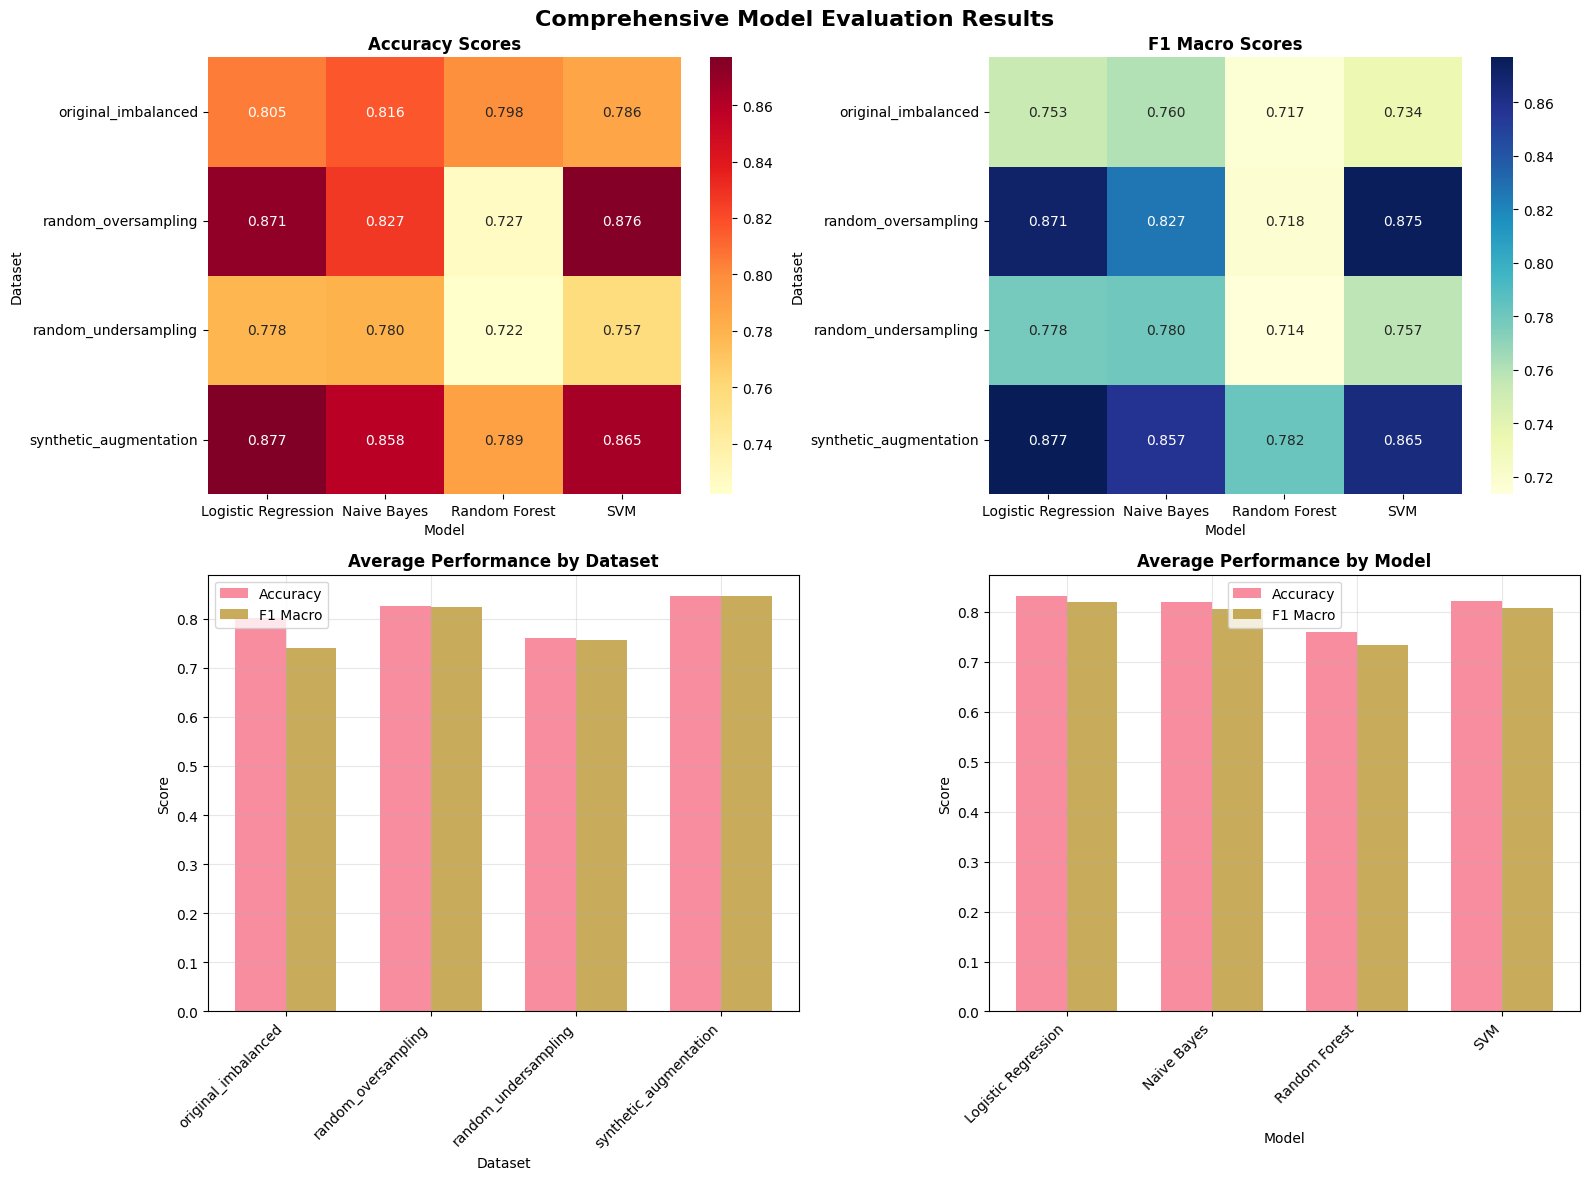

In [14]:
# Create comprehensive visualizations
if len(results_df) > 0:
    print("📊 Creating visualizations...")
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create a large figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Comprehensive Model Evaluation Results', fontsize=16, fontweight='bold')
    
    # 1. Accuracy Heatmap
    pivot_accuracy = results_df.pivot(index='dataset_name', columns='model_name', values='accuracy')
    sns.heatmap(pivot_accuracy, annot=True, fmt='.3f', cmap='YlOrRd', ax=axes[0,0])
    axes[0,0].set_title('Accuracy Scores', fontweight='bold')
    axes[0,0].set_xlabel('Model')
    axes[0,0].set_ylabel('Dataset')
    
    # 2. F1 Macro Heatmap
    pivot_f1_macro = results_df.pivot(index='dataset_name', columns='model_name', values='f1_macro')
    sns.heatmap(pivot_f1_macro, annot=True, fmt='.3f', cmap='YlGnBu', ax=axes[0,1])
    axes[0,1].set_title('F1 Macro Scores', fontweight='bold')
    axes[0,1].set_xlabel('Model')
    axes[0,1].set_ylabel('Dataset')
    
    # 3. Dataset Comparison Bar Plot
    dataset_avg = results_df.groupby('dataset_name')[['accuracy', 'f1_macro']].mean().reset_index()
    x = np.arange(len(dataset_avg))
    width = 0.35
    
    axes[1,0].bar(x - width/2, dataset_avg['accuracy'], width, label='Accuracy', alpha=0.8)
    axes[1,0].bar(x + width/2, dataset_avg['f1_macro'], width, label='F1 Macro', alpha=0.8)
    axes[1,0].set_xlabel('Dataset')
    axes[1,0].set_ylabel('Score')
    axes[1,0].set_title('Average Performance by Dataset', fontweight='bold')
    axes[1,0].set_xticks(x)
    axes[1,0].set_xticklabels(dataset_avg['dataset_name'], rotation=45, ha='right')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Model Comparison Bar Plot
    model_avg = results_df.groupby('model_name')[['accuracy', 'f1_macro']].mean().reset_index()
    x = np.arange(len(model_avg))
    
    axes[1,1].bar(x - width/2, model_avg['accuracy'], width, label='Accuracy', alpha=0.8)
    axes[1,1].bar(x + width/2, model_avg['f1_macro'], width, label='F1 Macro', alpha=0.8)
    axes[1,1].set_xlabel('Model')
    axes[1,1].set_ylabel('Score')
    axes[1,1].set_title('Average Performance by Model', fontweight='bold')
    axes[1,1].set_xticks(x)
    axes[1,1].set_xticklabels(model_avg['model_name'], rotation=45, ha='right')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ No results to visualize")

## 🎯 Detailed Analysis & Conclusions

In [15]:
# Detailed analysis and conclusions
if len(results_df) > 0 and 'synthetic_augmentation' in results_df['dataset_name'].values:
    
    print("🎯 DETAILED ANALYSIS: SYNTHETIC DATA EFFECTIVENESS")
    print("=" * 60)
    
    # Compare synthetic augmentation vs other methods
    synthetic_results = results_df[results_df['dataset_name'] == 'synthetic_augmentation']
    original_results = results_df[results_df['dataset_name'] == 'original_imbalanced']
    oversampling_results = results_df[results_df['dataset_name'] == 'random_oversampling']
    undersampling_results = results_df[results_df['dataset_name'] == 'random_undersampling']
    
    print("\n📊 SYNTHETIC AUGMENTATION vs BASELINES:")
    
    for model in models.keys():
        print(f"\n🤖 {model}:")
        
        # Get results for this model
        synthetic_model = synthetic_results[synthetic_results['model_name'] == model]
        original_model = original_results[original_results['model_name'] == model]
        oversample_model = oversampling_results[oversampling_results['model_name'] == model]
        undersample_model = undersampling_results[undersampling_results['model_name'] == model]
        
        if not synthetic_model.empty:
            synthetic_f1 = synthetic_model['f1_macro'].iloc[0]
            synthetic_acc = synthetic_model['accuracy'].iloc[0]
            
            print(f"   Synthetic - Accuracy: {synthetic_acc:.4f}, F1: {synthetic_f1:.4f}")
            
            # Compare with original
            if not original_model.empty:
                original_f1 = original_model['f1_macro'].iloc[0]
                original_acc = original_model['accuracy'].iloc[0]
                f1_improvement = synthetic_f1 - original_f1
                acc_improvement = synthetic_acc - original_acc
                
                print(f"   Original - Accuracy: {original_acc:.4f}, F1: {original_f1:.4f}")
                print(f"   📈 Improvement: Acc {acc_improvement:+.4f}, F1 {f1_improvement:+.4f}")
            
            # Compare with oversampling
            if not oversample_model.empty:
                oversample_f1 = oversample_model['f1_macro'].iloc[0]
                oversample_acc = oversample_model['accuracy'].iloc[0]
                print(f"   vs Random Oversample: Acc {synthetic_acc - oversample_acc:+.4f}, F1 {synthetic_f1 - oversample_f1:+.4f}")
            
            # Compare with undersampling
            if not undersample_model.empty:
                undersample_f1 = undersample_model['f1_macro'].iloc[0]
                undersample_acc = undersample_model['accuracy'].iloc[0]
                print(f"   vs Random Undersample: Acc {synthetic_acc - undersample_acc:+.4f}, F1 {synthetic_f1 - undersample_f1:+.4f}")
    
    # Overall conclusions
    print("\n🎯 KEY FINDINGS:")
    
    # Best overall method
    method_performance = results_df.groupby('dataset_name')[['accuracy', 'f1_macro']].mean()
    best_method = method_performance['f1_macro'].idxmax()
    best_f1 = method_performance.loc[best_method, 'f1_macro']
    
    print(f"🥇 Best overall method: {best_method.replace('_', ' ').title()}")
    print(f"📊 Average F1 Macro: {best_f1:.4f}")
    
    # Synthetic data effectiveness
    if best_method == 'synthetic_augmentation':
        print("\n✅ SUCCESS: Synthetic headline generation is the most effective approach!")
        print("🎯 Our GPT-generated synthetic headlines outperform traditional balancing methods")
    else:
        synthetic_rank = method_performance['f1_macro'].rank(ascending=False)['synthetic_augmentation']
        print(f"\n📊 Synthetic augmentation ranks #{int(synthetic_rank)} out of {len(method_performance)}")
        
        if synthetic_rank <= 2:
            print("✅ GOOD: Synthetic headlines perform competitively with traditional methods")
        else:
            print("⚠️ MIXED: Synthetic headlines show promise but may need refinement")
    
    # Model recommendations
    best_model_overall = results_df.groupby('model_name')[['accuracy', 'f1_macro']].mean()['f1_macro'].idxmax()
    print(f"\n🤖 Best performing model overall: {best_model_overall}")
    
    # Specific recommendations for synthetic data
    if not synthetic_results.empty:
        best_model_synthetic = synthetic_results.loc[synthetic_results['f1_macro'].idxmax(), 'model_name']
        best_synthetic_f1 = synthetic_results['f1_macro'].max()
        print(f"🎯 Best model for synthetic data: {best_model_synthetic} (F1: {best_synthetic_f1:.4f})")

else:
    print("❌ Insufficient data for detailed analysis")
    print("⚠️ Ensure synthetic augmentation dataset was created successfully")

🎯 DETAILED ANALYSIS: SYNTHETIC DATA EFFECTIVENESS

📊 SYNTHETIC AUGMENTATION vs BASELINES:

🤖 Random Forest:
   Synthetic - Accuracy: 0.7887, F1: 0.7823
   Original - Accuracy: 0.7981, F1: 0.7169
   📈 Improvement: Acc -0.0094, F1 +0.0655
   vs Random Oversample: Acc +0.0621, F1 +0.0644
   vs Random Undersample: Acc +0.0665, F1 +0.0687

🤖 Logistic Regression:
   Synthetic - Accuracy: 0.8769, F1: 0.8768
   Original - Accuracy: 0.8046, F1: 0.7530
   📈 Improvement: Acc +0.0724, F1 +0.1238
   vs Random Oversample: Acc +0.0060, F1 +0.0059
   vs Random Undersample: Acc +0.0986, F1 +0.0985

🤖 SVM:
   Synthetic - Accuracy: 0.8647, F1: 0.8646
   Original - Accuracy: 0.7864, F1: 0.7340
   📈 Improvement: Acc +0.0783, F1 +0.1306
   vs Random Oversample: Acc -0.0108, F1 -0.0108
   vs Random Undersample: Acc +0.1073, F1 +0.1072

🤖 Naive Bayes:
   Synthetic - Accuracy: 0.8581, F1: 0.8570
   Original - Accuracy: 0.8160, F1: 0.7604
   📈 Improvement: Acc +0.0421, F1 +0.0966
   vs Random Oversample: Acc +0

## 💾 Save Results

In [16]:
# Save comprehensive results
if len(results_df) > 0:
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Save detailed results
    results_filename = f'classification_evaluation_results_{timestamp}.csv'
    results_df.to_csv(results_filename, index=False)
    print(f"💾 Detailed results saved: {results_filename}")
    
    # Save summary
    summary_data = {
        'experiment_info': {
            'timestamp': timestamp,
            'total_experiments': len(results_df),
            'datasets_tested': results_df['dataset_name'].unique().tolist(),
            'models_tested': results_df['model_name'].unique().tolist()
        },
        'best_performers': {
            'best_accuracy': {
                'score': float(results_df['accuracy'].max()),
                'model': results_df.loc[results_df['accuracy'].idxmax(), 'model_name'],
                'dataset': results_df.loc[results_df['accuracy'].idxmax(), 'dataset_name']
            },
            'best_f1_macro': {
                'score': float(results_df['f1_macro'].max()),
                'model': results_df.loc[results_df['f1_macro'].idxmax(), 'model_name'],
                'dataset': results_df.loc[results_df['f1_macro'].idxmax(), 'dataset_name']
            }
        },
        'method_rankings': results_df.groupby('dataset_name')[['accuracy', 'f1_macro']].mean().sort_values('f1_macro', ascending=False).to_dict()
    }
    
    summary_filename = f'classification_evaluation_summary_{timestamp}.json'
    with open(summary_filename, 'w') as f:
        json.dump(summary_data, f, indent=2)
    
    print(f"💾 Summary saved: {summary_filename}")
    
    print(f"\n✅ EVALUATION COMPLETE!")
    print(f"📊 Results ready for analysis and publication")
    print(f"🎯 Check the saved files for detailed metrics and insights")
    
else:
    print("❌ No results to save")

💾 Detailed results saved: classification_evaluation_results_20251030_090436.csv
💾 Summary saved: classification_evaluation_summary_20251030_090436.json

✅ EVALUATION COMPLETE!
📊 Results ready for analysis and publication
🎯 Check the saved files for detailed metrics and insights


## 🧬 Synthetic Data Quality Validation Experiment

This experiment tests the quality of our synthetic headlines by comparing how models trained on original imbalanced data perform when tested on:
1. **Original minority class data** (real fake headlines)
2. **Our synthetic headlines**

**Hypothesis:** If our synthetic headlines are high quality, a model trained on original imbalanced data should perform similarly on synthetic headlines as it does on real minority class headlines.

**Key Insight:** This tests whether synthetic data exhibits the same patterns and characteristics as real minority class data.

In [17]:
# Synthetic Data Quality Validation Experiment
print("🧬 SYNTHETIC DATA QUALITY VALIDATION EXPERIMENT (with proper train/test split)")
print("=" * 60)

if synthetic_headlines and len(synthetic_headlines) > 0:
    print("🎯 Testing if synthetic headlines behave like real minority class data (using proper train/test split)")
    print("📝 Strategy: Split original imbalanced data into train/test, train on train set, test on test set and synthetic data")
    print()
    
    # Get the original imbalanced dataset (without any synthetic augmentation)
    original_dataset = datasets['original_imbalanced']
    
    print(f"📊 Original dataset info:")
    print(f"   Total samples: {len(original_dataset):,}")
    print(f"   Majority class ({majority_class}): {len(original_dataset[original_dataset['label'] == majority_class]):,}")
    print(f"   Minority class ({minority_class}): {len(original_dataset[original_dataset['label'] == minority_class]):,}")
    
    # Split into train/test (stratified)
    train_data, test_data = train_test_split(
        original_dataset, test_size=0.2, random_state=RANDOM_STATE, stratify=original_dataset['label']
    )
    print(f"   Train set: {len(train_data):,} samples")
    print(f"   Test set: {len(test_data):,} samples")
    print(f"   Test set minority class: {sum(test_data['label'] == minority_class):,}")
    
    # 1. Test set: only minority class samples (real fake headlines, unseen)
    test_minority = test_data[test_data['label'] == minority_class].copy()
    print(f"   1. Test set minority class: {len(test_minority):,} samples")
    
    # 2. Synthetic headlines test set
    synthetic_test_data = []
    for headline in synthetic_headlines:
        synthetic_test_data.append({
            'headline': headline,
            'label': minority_class,  # Same label as minority class
            'source': 'gpt_synthetic',
            'is_synthetic': True
        })
    synthetic_test_df = pd.DataFrame(synthetic_test_data)
    print(f"   2. Synthetic headlines test: {len(synthetic_test_df):,} samples")
    
    # Store validation results
    validation_results = []
    
    print(f"\n🚀 Running validation experiments...")
    
else:
    print("❌ No synthetic headlines available for validation experiment")
    print("⚠️ Skipping synthetic data quality validation")

🧬 SYNTHETIC DATA QUALITY VALIDATION EXPERIMENT (with proper train/test split)
🎯 Testing if synthetic headlines behave like real minority class data (using proper train/test split)
📝 Strategy: Split original imbalanced data into train/test, train on train set, test on test set and synthetic data

📊 Original dataset info:
   Total samples: 23,128
   Majority class (1): 17,388
   Minority class (0): 5,740
   Train set: 18,502 samples
   Test set: 4,626 samples
   Test set minority class: 1,148
   1. Test set minority class: 1,148 samples
   2. Synthetic headlines test: 11,668 samples

🚀 Running validation experiments...


In [18]:
# Train on original train set, test on (1) real minority test set, (2) synthetic data (unseen)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

models = {
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'SVM': SVC(probability=True, random_state=RANDOM_STATE),
    'Naive Bayes': MultinomialNB(),
}

acceptable_diff = 0.10  # 10% absolute difference is acceptable
borderline_diff = 0.05  # 5% is considered very good

validation_results = []

for model_name, model in models.items():
    print(f"\n--- {model_name} ---")
    # Vectorize
    vectorizer = CountVectorizer()
    X_train = vectorizer.fit_transform(train_data['headline'])
    y_train = train_data['label']
    
    # Train
    model.fit(X_train, y_train)
    
    # Test on real minority class (unseen)
    X_test_minority = vectorizer.transform(test_minority['headline'])
    y_test_minority = test_minority['label']
    y_pred_minority = model.predict(X_test_minority)
    acc_minority = accuracy_score(y_test_minority, y_pred_minority)
    f1_minority = f1_score(y_test_minority, y_pred_minority, pos_label=minority_class)
    
    # Test on synthetic data (unseen)
    X_synth = vectorizer.transform(synthetic_test_df['headline'])
    y_synth = synthetic_test_df['label']
    y_pred_synth = model.predict(X_synth)
    acc_synth = accuracy_score(y_synth, y_pred_synth)
    f1_synth = f1_score(y_synth, y_pred_synth, pos_label=minority_class)
    
    acc_diff = acc_synth - acc_minority
    f1_diff = f1_synth - f1_minority
    
    # Quality assessment
    if abs(acc_diff) <= borderline_diff and abs(f1_diff) <= borderline_diff:
        quality = 'EXCELLENT'
    elif abs(acc_diff) <= acceptable_diff and abs(f1_diff) <= acceptable_diff:
        quality = 'GOOD'
    else:
        quality = 'POOR'
    
    validation_results.append({
        'Model': model_name,
        'Minority Acc': acc_minority,
        'Synthetic Acc': acc_synth,
        'Acc Diff': acc_diff,
        'Minority F1': f1_minority,
        'Synthetic F1': f1_synth,
        'F1 Diff': f1_diff,
        'Quality': quality
    })


--- Random Forest ---

--- Logistic Regression ---

--- Logistic Regression ---

--- SVM ---

--- SVM ---

--- Naive Bayes ---

--- Naive Bayes ---


In [19]:
# Show summary table and quality assessment for synthetic data validation (with proper split)
import pandas as pd

validation_df = pd.DataFrame(validation_results)

if not validation_df.empty:
    print("\n📊 SYNTHETIC DATA QUALITY VALIDATION RESULTS (with proper train/test split)")
    print("="*60)
    print("\n🎯 SUMMARY TABLE:")
    print(validation_df[['Model', 'Minority Acc', 'Synthetic Acc', 'Acc Diff', 'Minority F1', 'Synthetic F1', 'F1 Diff', 'Quality']].to_string(index=False, float_format=lambda x: f"{x:.4f}"))
    print()
    
    # Overall quality assessment
    quality_counts = validation_df['Quality'].value_counts()
    total = len(validation_df)
    print(f"🏆 OVERALL QUALITY ASSESSMENT:")
    for q in ['EXCELLENT', 'GOOD', 'POOR']:
        if q in quality_counts:
            print(f"   {q}: {quality_counts[q]}/{total} ({100*quality_counts[q]/total:.1f}%)")
    print()
    
    # Performance analysis
    best_idx = (validation_df['Acc Diff'].abs() + validation_df['F1 Diff'].abs()).idxmin()
    worst_idx = (validation_df['Acc Diff'].abs() + validation_df['F1 Diff'].abs()).idxmax()
    print("📈 PERFORMANCE ANALYSIS:")
    print(f"🥇 Best synthetic data match: {validation_df.loc[best_idx, 'Model']}")
    print(f"   Combined difference: {abs(validation_df.loc[best_idx, 'Acc Diff']) + abs(validation_df.loc[best_idx, 'F1 Diff']):.4f}")
    print(f"   Quality: {validation_df.loc[best_idx, 'Quality']}")
    print(f"🔴 Largest synthetic data difference: {validation_df.loc[worst_idx, 'Model']}")
    print(f"   Combined difference: {abs(validation_df.loc[worst_idx, 'Acc Diff']) + abs(validation_df.loc[worst_idx, 'F1 Diff']):.4f}")
    print(f"   Quality: {validation_df.loc[worst_idx, 'Quality']}")
    print()
    
    # Statistical summary
    print("📊 STATISTICAL SUMMARY:")
    print(f"   Average accuracy difference: {validation_df['Acc Diff'].mean():.4f} ± {validation_df['Acc Diff'].std():.4f}")
    print(f"   Average F1 difference: {validation_df['F1 Diff'].mean():.4f} ± {validation_df['F1 Diff'].std():.4f}")
    print()
    
    # Interpretation
    print("🎯 INTERPRETATION:")
    if (validation_df['Quality'] == 'EXCELLENT').any():
        print("✅ EXCELLENT: Your synthetic headlines are highly realistic!")
    elif (validation_df['Quality'] == 'GOOD').any():
        print("🟡 GOOD: Your synthetic headlines are reasonably realistic, but could be improved.")
    else:
        print("❌ POOR: Your synthetic headlines may need significant improvement")
        print("🎯 Consider refining your synthetic data generation approach")
else:
    print("No validation results to display.")


📊 SYNTHETIC DATA QUALITY VALIDATION RESULTS (with proper train/test split)

🎯 SUMMARY TABLE:
              Model  Minority Acc  Synthetic Acc  Acc Diff  Minority F1  Synthetic F1  F1 Diff Quality
      Random Forest        0.4625         0.0355   -0.4271       0.6325        0.0685  -0.5640    POOR
Logistic Regression        0.5557         0.0474   -0.5084       0.7144        0.0905  -0.6239    POOR
                SVM        0.4416         0.0232   -0.4184       0.6127        0.0454  -0.5673    POOR
        Naive Bayes        0.6141         0.2242   -0.3899       0.7609        0.3663  -0.3946    POOR

🏆 OVERALL QUALITY ASSESSMENT:
   POOR: 4/4 (100.0%)

📈 PERFORMANCE ANALYSIS:
🥇 Best synthetic data match: Naive Bayes
   Combined difference: 0.7846
   Quality: POOR
🔴 Largest synthetic data difference: Logistic Regression
   Combined difference: 1.1323
   Quality: POOR

📊 STATISTICAL SUMMARY:
   Average accuracy difference: -0.4359 ± 0.0508
   Average F1 difference: -0.5375 ± 0.0991

🎯 

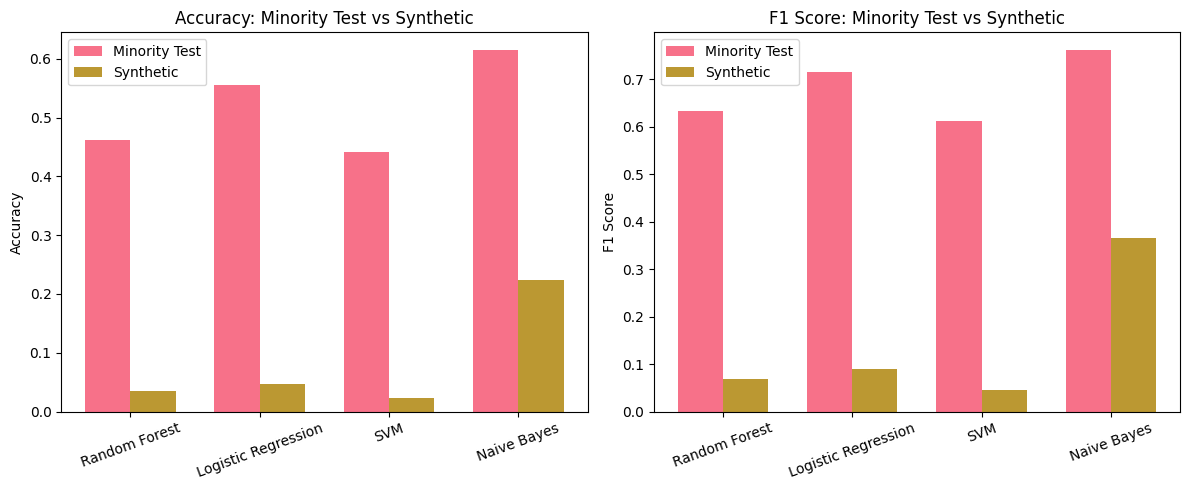

In [20]:
# Visualize synthetic data validation results (with proper split)
import matplotlib.pyplot as plt
import numpy as np

if not validation_df.empty:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    x = np.arange(len(validation_df['Model']))
    width = 0.35
    
    # Accuracy
    axes[0].bar(x - width/2, validation_df['Minority Acc'], width, label='Minority Test')
    axes[0].bar(x + width/2, validation_df['Synthetic Acc'], width, label='Synthetic')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(validation_df['Model'], rotation=20)
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Accuracy: Minority Test vs Synthetic')
    axes[0].legend()
    
    # F1
    axes[1].bar(x - width/2, validation_df['Minority F1'], width, label='Minority Test')
    axes[1].bar(x + width/2, validation_df['Synthetic F1'], width, label='Synthetic')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(validation_df['Model'], rotation=20)
    axes[1].set_ylabel('F1 Score')
    axes[1].set_title('F1 Score: Minority Test vs Synthetic')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("No validation results to visualize.")

In [21]:
# Save validation results (with proper split)
import datetime

if not validation_df.empty:
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    validation_filename = f"synthetic_validation_results_{timestamp}.csv"
    validation_df.to_csv(validation_filename, index=False)
    print(f"Validation results saved to {validation_filename}")
else:
    print("No validation results to save.")

Validation results saved to synthetic_validation_results_20251030_091142.csv


# 🔬 Synthetic Data Quality Validation with Neural and Transformer Models

We repeat the synthetic data quality validation experiment using neural network and transformer-based models (e.g., simple feedforward NN, DistilBERT, and RoBERTa). This will help us assess whether more powerful models can better generalize between real minority and synthetic data, and if the similarity between the two is higher for these models.

In [22]:
# Neural and Transformer Model Validation (Optimized for GTX 1060 6GB)
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score
import torch
import numpy as np

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# Helper: HuggingFace dataset preparation
def prepare_hf_dataset(df, tokenizer, max_length=64):  # Reduced from 128 to save memory
    encodings = tokenizer(list(df['headline']), truncation=True, padding=True, max_length=max_length)
    labels = list(df['label'])
    return {**encodings, 'labels': labels}

# Model configs - Using smaller/more efficient models for 6GB VRAM
transformer_models = [
    ('distilbert-base-uncased', 'DistilBERT'),  # ~250MB model
    # ('roberta-base', 'RoBERTa')  # Commented out - RoBERTa is larger, may cause OOM
]

nn_validation_results = []

for model_ckpt, model_name in transformer_models:
    print(f"\n--- {model_name} ---")
    
    # Clear GPU cache before each model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=2)
    
    # Move model to GPU if available
    model.to(device)
    
    # Prepare datasets
    train_enc = prepare_hf_dataset(train_data, tokenizer)
    test_min_enc = prepare_hf_dataset(test_minority, tokenizer)
    synth_enc = prepare_hf_dataset(synthetic_test_df, tokenizer)
    
    # Convert to torch Dataset
    class SimpleDataset(torch.utils.data.Dataset):
        def __init__(self, encodings):
            self.encodings = encodings
        def __getitem__(self, idx):
            return {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        def __len__(self):
            return len(self.encodings['input_ids'])
    
    train_ds = SimpleDataset(train_enc)
    test_min_ds = SimpleDataset(test_min_enc)
    synth_ds = SimpleDataset(synth_enc)
    
    # Trainer with memory-optimized settings for GTX 1060
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=1,  # Reduced from 2 to save time and memory
        per_device_train_batch_size=8,  # Reduced from 16 to fit in 6GB VRAM
        per_device_eval_batch_size=16,  # Reduced from 32
        gradient_accumulation_steps=2,  # Simulate larger batch size
        logging_steps=50,
        save_steps=1000,
        eval_strategy='no',
        report_to=[],
        learning_rate=2e-5,
        seed=RANDOM_STATE,
        dataloader_pin_memory=False,  # Reduce memory usage
        fp16=True,  # Use mixed precision to save memory
        remove_unused_columns=True,
        warmup_steps=100,
        weight_decay=0.01
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        tokenizer=tokenizer
    )
    
    print(f"Training {model_name} (1 epoch, batch_size=8, fp16=True)...")
    trainer.train()
    
    # Predict on test_minority
    print("Predicting on minority test set...")
    preds_min = trainer.predict(test_min_ds)
    y_pred_min = np.argmax(preds_min.predictions, axis=1)
    y_true_min = np.array(test_minority['label'])
    acc_min = accuracy_score(y_true_min, y_pred_min)
    f1_min = f1_score(y_true_min, y_pred_min, pos_label=minority_class)
    
    # Predict on synthetic
    print("Predicting on synthetic test set...")
    preds_synth = trainer.predict(synth_ds)
    y_pred_synth = np.argmax(preds_synth.predictions, axis=1)
    y_true_synth = np.array(synthetic_test_df['label'])
    acc_synth = accuracy_score(y_true_synth, y_pred_synth)
    f1_synth = f1_score(y_true_synth, y_pred_synth, pos_label=minority_class)
    
    acc_diff = acc_synth - acc_min
    f1_diff = f1_synth - f1_min
    
    # Quality assessment
    if abs(acc_diff) <= borderline_diff and abs(f1_diff) <= borderline_diff:
        quality = 'EXCELLENT'
    elif abs(acc_diff) <= acceptable_diff and abs(f1_diff) <= acceptable_diff:
        quality = 'GOOD'
    else:
        quality = 'POOR'
    
    nn_validation_results.append({
        'Model': model_name,
        'Minority Acc': acc_min,
        'Synthetic Acc': acc_synth,
        'Acc Diff': acc_diff,
        'Minority F1': f1_min,
        'Synthetic F1': f1_synth,
        'F1 Diff': f1_diff,
        'Quality': quality
    })
    
    print(f"✅ {model_name} completed - Minority F1: {f1_min:.4f}, Synthetic F1: {f1_synth:.4f}")
    
    # Clean up model from GPU memory
    del model, trainer
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print("\n🎯 All transformer models completed!")

Using device: cpu

--- DistilBERT ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training DistilBERT (1 epoch, batch_size=8, fp16=True)...


Step,Training Loss
50,0.633800
100,0.524000
150,0.461400
200,0.465800
250,0.423300
300,0.402900
350,0.378600
400,0.383400
450,0.382100
500,0.392800


Predicting on minority test set...


Predicting on synthetic test set...


✅ DistilBERT completed - Minority F1: 0.7582, Synthetic F1: 0.1469

🎯 All transformer models completed!


In [23]:
# Show summary table and quality assessment for neural/transformer models
nn_validation_df = pd.DataFrame(nn_validation_results)

if not nn_validation_df.empty:
    print("\n📊 SYNTHETIC DATA QUALITY VALIDATION RESULTS (Neural/Transformer Models)")
    print("="*60)
    print("\n🎯 SUMMARY TABLE:")
    print(nn_validation_df[['Model', 'Minority Acc', 'Synthetic Acc', 'Acc Diff', 'Minority F1', 'Synthetic F1', 'F1 Diff', 'Quality']].to_string(index=False, float_format=lambda x: f"{x:.4f}"))
    print()
    
    # Overall quality assessment
    quality_counts = nn_validation_df['Quality'].value_counts()
    total = len(nn_validation_df)
    print(f"🏆 OVERALL QUALITY ASSESSMENT:")
    for q in ['EXCELLENT', 'GOOD', 'POOR']:
        if q in quality_counts:
            print(f"   {q}: {quality_counts[q]}/{total} ({100*quality_counts[q]/total:.1f}%)")
    print()
    
    # Performance analysis
    best_idx = (nn_validation_df['Acc Diff'].abs() + nn_validation_df['F1 Diff'].abs()).idxmin()
    worst_idx = (nn_validation_df['Acc Diff'].abs() + nn_validation_df['F1 Diff'].abs()).idxmax()
    print("📈 PERFORMANCE ANALYSIS:")
    print(f"🥇 Best synthetic data match: {nn_validation_df.loc[best_idx, 'Model']}")
    print(f"   Combined difference: {abs(nn_validation_df.loc[best_idx, 'Acc Diff']) + abs(nn_validation_df.loc[best_idx, 'F1 Diff']):.4f}")
    print(f"   Quality: {nn_validation_df.loc[best_idx, 'Quality']}")
    print(f"🔴 Largest synthetic data difference: {nn_validation_df.loc[worst_idx, 'Model']}")
    print(f"   Combined difference: {abs(nn_validation_df.loc[worst_idx, 'Acc Diff']) + abs(nn_validation_df.loc[worst_idx, 'F1 Diff']):.4f}")
    print(f"   Quality: {nn_validation_df.loc[worst_idx, 'Quality']}")
    print()
    
    # Statistical summary
    print("📊 STATISTICAL SUMMARY:")
    print(f"   Average accuracy difference: {nn_validation_df['Acc Diff'].mean():.4f} ± {nn_validation_df['Acc Diff'].std():.4f}")
    print(f"   Average F1 difference: {nn_validation_df['F1 Diff'].mean():.4f} ± {nn_validation_df['F1 Diff'].std():.4f}")
    print()
    
    # Interpretation
    print("🎯 INTERPRETATION:")
    if (nn_validation_df['Quality'] == 'EXCELLENT').any():
        print("✅ EXCELLENT: Your synthetic headlines are highly realistic for neural/transformer models!")
    elif (nn_validation_df['Quality'] == 'GOOD').any():
        print("🟡 GOOD: Your synthetic headlines are reasonably realistic for neural/transformer models, but could be improved.")
    else:
        print("❌ POOR: Your synthetic headlines may need significant improvement, even for neural/transformer models.")
        print("🎯 Consider refining your synthetic data generation approach.")
else:
    print("No neural/transformer validation results to display.")


📊 SYNTHETIC DATA QUALITY VALIDATION RESULTS (Neural/Transformer Models)

🎯 SUMMARY TABLE:
     Model  Minority Acc  Synthetic Acc  Acc Diff  Minority F1  Synthetic F1  F1 Diff Quality
DistilBERT        0.6106         0.0793   -0.5314       0.7582        0.1469  -0.6113    POOR

🏆 OVERALL QUALITY ASSESSMENT:
   POOR: 1/1 (100.0%)

📈 PERFORMANCE ANALYSIS:
🥇 Best synthetic data match: DistilBERT
   Combined difference: 1.1427
   Quality: POOR
🔴 Largest synthetic data difference: DistilBERT
   Combined difference: 1.1427
   Quality: POOR

📊 STATISTICAL SUMMARY:
   Average accuracy difference: -0.5314 ± nan
   Average F1 difference: -0.6113 ± nan

🎯 INTERPRETATION:
❌ POOR: Your synthetic headlines may need significant improvement, even for neural/transformer models.
🎯 Consider refining your synthetic data generation approach.


In [25]:
# Save the best performing model and benchmark metrics for synthetic headline validation
import pickle
import joblib
from pathlib import Path
import json
from datetime import datetime

# Create model directory if it doesn't exist
model_dir = Path('/home/mateja/Documents/IJS/current/Fairer_Models/saved_models')
model_dir.mkdir(exist_ok=True)

print("🎯 SAVING BASELINE MODEL FOR SYNTHETIC HEADLINE VALIDATION")
print("=" * 60)

# Check what validation results we have available
print("📊 Checking available validation results...")
print(f"   validation_results available: {'validation_results' in globals()}")
print(f"   models available: {'models' in globals()}")
print(f"   train_data available: {'train_data' in globals()}")
print(f"   vectorizer available: {'vectorizer' in globals()}")

if 'validation_results' in globals():
    print(f"   Number of validation results: {len(validation_results)}")
    for i, result in enumerate(validation_results):
        print(f"     {i+1}. {result['Model']}: F1={result['Minority F1']:.3f}, Acc={result['Minority Acc']:.3f}")

# Find the best performing model from our validation results
best_model_name = None
best_model_obj = None
best_minority_accuracy = 0
best_minority_f1 = 0

if 'validation_results' in globals() and len(validation_results) > 0:
    # Get the model with the highest minority F1 from validation results
    best_validation_result = max(validation_results, key=lambda x: x['Minority F1'])
    best_model_name = best_validation_result['Model']
    best_minority_accuracy = best_validation_result['Minority Acc']
    best_minority_f1 = best_validation_result['Minority F1']
    
    print(f"\n🏆 Best performing model from validation: {best_model_name}")
    print(f"   Minority accuracy: {best_minority_accuracy:.3f}")
    print(f"   Minority F1: {best_minority_f1:.3f}")
    
    # Get the corresponding model object (need to retrain it)
    if 'models' in globals() and best_model_name in models:
        best_model_obj = models[best_model_name]
        print(f"   ✅ Found model object: {type(best_model_obj).__name__}")
    else:
        print(f"   ❌ Could not find model object for {best_model_name}")
        print(f"   Available models: {list(models.keys()) if 'models' in globals() else 'None'}")

elif 'models' in globals() and len(models) > 0:
    # Fallback: use the first available model
    best_model_name = list(models.keys())[0]
    best_model_obj = models[best_model_name]
    # Use dummy metrics - will be updated after training
    best_minority_accuracy = 0.5
    best_minority_f1 = 0.5
    
    print(f"📝 Using fallback model: {best_model_name}")
    print(f"   Will establish benchmark metrics after training")

if best_model_obj is not None and 'train_data' in globals() and 'vectorizer' in globals():
    # Re-train the model on the training data from our validation experiment
    print(f"\n🔄 Training {best_model_name} on original training dataset...")
    
    # Use the same train_data from validation experiment
    X_train_final = vectorizer.transform(train_data['headline'])
    y_train_final = train_data['label']
    
    # Train the model
    best_model_obj.fit(X_train_final, y_train_final)
    print(f"   ✅ Model trained on {len(train_data):,} samples")
    
    # If we don't have validation metrics, test on test_minority to get them
    if best_minority_accuracy == 0.5 and 'test_minority' in globals():
        print(f"   🧪 Evaluating model on minority test set to establish benchmarks...")
        X_test_min = vectorizer.transform(test_minority['headline'])
        y_test_min = test_minority['label']
        y_pred_min = best_model_obj.predict(X_test_min)
        
        from sklearn.metrics import accuracy_score, f1_score
        best_minority_accuracy = accuracy_score(y_test_min, y_pred_min)
        best_minority_f1 = f1_score(y_test_min, y_pred_min, pos_label=minority_class)
        
        print(f"   📊 Established benchmarks - Accuracy: {best_minority_accuracy:.3f}, F1: {best_minority_f1:.3f}")
    
    # Save model and vectorizer
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_filename = model_dir / f"baseline_classifier_{best_model_name.replace(' ', '_')}_{timestamp}.pkl"
    vectorizer_filename = model_dir / f"baseline_vectorizer_{timestamp}.pkl"
    metrics_filename = model_dir / f"baseline_metrics_{timestamp}.json"
    
    # Save model
    joblib.dump(best_model_obj, model_filename)
    print(f"✅ Saved model: {model_filename}")
    
    # Save vectorizer
    joblib.dump(vectorizer, vectorizer_filename)
    print(f"✅ Saved vectorizer: {vectorizer_filename}")
    
    # Save benchmark metrics
    benchmark_metrics = {
        'model_name': best_model_name,
        'minority_accuracy_threshold': float(best_minority_accuracy),
        'minority_f1_threshold': float(best_minority_f1),
        'training_data_size': len(train_data) if 'train_data' in globals() else 0,
        'test_data_size': len(test_data) if 'test_data' in globals() else 0,
        'minority_class': int(minority_class) if 'minority_class' in globals() else 0,
        'majority_class': int(majority_class) if 'majority_class' in globals() else 1,
        'timestamp': timestamp,
        'model_file': str(model_filename),
        'vectorizer_file': str(vectorizer_filename),
        'validation_note': 'Synthetic headlines must exceed these thresholds to be considered high-quality'
    }
    
    with open(metrics_filename, 'w') as f:
        json.dump(benchmark_metrics, f, indent=2)
    
    print(f"✅ Saved benchmark metrics: {metrics_filename}")
    
    # Store for use in other notebooks
    globals()['BASELINE_MODEL_PATH'] = str(model_filename)
    globals()['BASELINE_VECTORIZER_PATH'] = str(vectorizer_filename)
    globals()['BASELINE_METRICS_PATH'] = str(metrics_filename)
    globals()['BASELINE_MINORITY_ACCURACY'] = best_minority_accuracy
    globals()['BASELINE_MINORITY_F1'] = best_minority_f1
    
    print(f"\n🎯 BENCHMARK ESTABLISHED FOR SYNTHETIC HEADLINE VALIDATION:")
    print(f"   Model: {best_model_name}")
    print(f"   Minority Accuracy Threshold: {best_minority_accuracy:.3f}")
    print(f"   Minority F1 Threshold: {best_minority_f1:.3f}")
    print(f"   📝 Synthetic headlines must exceed these thresholds to be considered 'exaggerated fake features'")
    print(f"\n💡 Use these files in the advanced synthetic headline generation notebook:")
    print(f"   Model: {model_filename.name}")
    print(f"   Vectorizer: {vectorizer_filename.name}")
    print(f"   Metrics: {metrics_filename.name}")

else:
    print("❌ Missing required components for model saving:")
    print(f"   Model object: {best_model_obj is not None}")
    print(f"   Training data: {'train_data' in globals()}")
    print(f"   Vectorizer: {'vectorizer' in globals()}")
    print("⚠️ Please ensure the validation experiment was run successfully")

🎯 SAVING BASELINE MODEL FOR SYNTHETIC HEADLINE VALIDATION
📊 Checking available validation results...
   validation_results available: True
   models available: True
   train_data available: True
   vectorizer available: True
   Number of validation results: 4
     1. Random Forest: F1=0.633, Acc=0.463
     2. Logistic Regression: F1=0.714, Acc=0.556
     3. SVM: F1=0.613, Acc=0.442
     4. Naive Bayes: F1=0.761, Acc=0.614

🏆 Best performing model from validation: Naive Bayes
   Minority accuracy: 0.614
   Minority F1: 0.761
   ✅ Found model object: MultinomialNB

🔄 Training Naive Bayes on original training dataset...
   ✅ Model trained on 18,502 samples
✅ Saved model: /home/mateja/Documents/IJS/current/Fairer_Models/saved_models/baseline_classifier_Naive_Bayes_20251030_095322.pkl
✅ Saved vectorizer: /home/mateja/Documents/IJS/current/Fairer_Models/saved_models/baseline_vectorizer_20251030_095322.pkl
✅ Saved benchmark metrics: /home/mateja/Documents/IJS/current/Fairer_Models/saved_model